In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import maxentep
import numpy as np
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
import tensorflow as tf
import networkx as nx
from keras.callbacks import ReduceLROnPlateau

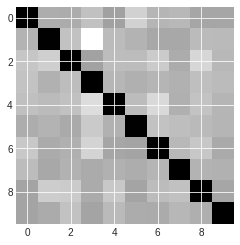

In [2]:
# Make up some population area and mobility network
np.random.seed(0)
M = 10
patches=[f'patch {i}' for i in range(M)]
population = np.round(np.random.normal(loc=500000, scale=300000, size=(M,)))
area = np.maximum(300, np.round(np.random.normal(loc=2000, scale=1000, size=(M,)), 0))
# defining a fully connected mobility matrix
dense_mobility_matrix = np.round(np.abs(np.random.normal(loc=100, scale=50, size=(M,M))))
# setting diagonal values to be dominant
dense_mobility_matrix_diag = np.round(np.abs(np.random.normal(loc=100000, scale=3000, size=(M))))
np.fill_diagonal(dense_mobility_matrix, dense_mobility_matrix_diag)
dense_mobility_matrix_norm = dense_mobility_matrix / np.sum(dense_mobility_matrix, axis=1, keepdims=True)
plt.imshow(np.log(dense_mobility_matrix))
compartments = ['E', 'A', 'I', 'R']
full_compartments = ['S'] + compartments
true_node = 1
infections_compartments = [1,2]
C = len(compartments)

In [3]:
def gen_ref_traj(graph, beta_A = 0.025, beta_I=0.05, alpha =1/3, gamma=1/2, mu=1/7, M=10, C=4, timesteps=100,
                 mobility_matrix=dense_mobility_matrix, population=None, area= None, true_node=None):
    # sparsify mobility matrix for sparse graphs
    sparsed_mobility_matrix = maxentep.sparse_graph_mobility(graph, mobility_matrix)
    tmat = maxentep.TransitionMatrix(compartments, [1,2])
    tmat.add_transition('E', 'A', 1/alpha, 0) # calling this alpha
    tmat.add_transition('E', 'I', 1/gamma, 0) # calling this gamma
    tmat.add_transition('A', 'R',1/mu, 0) # mu
    tmat.add_transition('I', 'R', 1/mu, 0) # mu
    infect_fxn = maxentep.contact_infection_func(infections_compartments, area=area)
    model = maxentep.MetaModel(infect_fxn, timesteps, populations=np.array(population))
    # starting fractions probabilities
    start = np.zeros((M,C)) #anywhere
    # Assume starting from Node true_node
    initial_exposed = 1/population[true_node]
    start[true_node,0] = initial_exposed
    sparsed_mobility_matrix_norm = sparsed_mobility_matrix / np.sum(sparsed_mobility_matrix, axis=1, keepdims=True)
    ref_traj = model(sparsed_mobility_matrix_norm, tmat.value, start, np.array([beta_A,beta_I]))[0]
    ref_traj = ref_traj[tf.newaxis, ...]
    return ref_traj



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Plotting 10 patches in a 3 x 4 grid


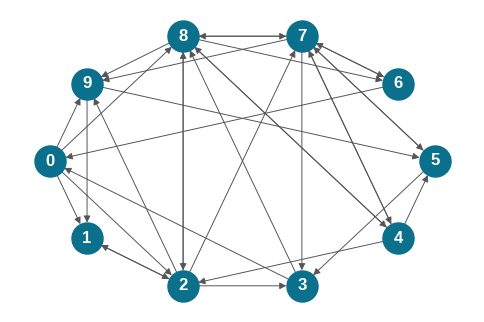

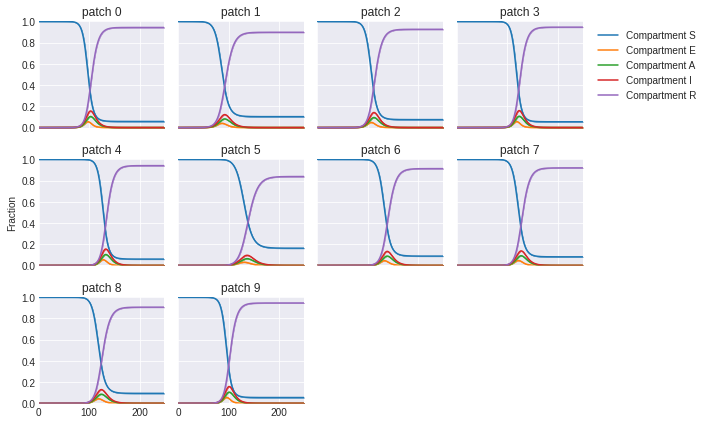

In [4]:
M=10
p = 0.4
graph = maxentep.gen_random_graph(M,p)
maxentep.draw_graph(graph, dpi =100)
maxentep.graph_degree(graph)
ref_traj = gen_ref_traj(graph, timesteps=250, population=population,
                          area=area, true_node=true_node)
maxentep.patch_quantile(ref_traj, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])

In [5]:
def gen_restraints(ref_traj, prior=None, start=None, end=None):
    if prior:
        prior = maxentep.Laplace(1)
    else:
        prior = maxentep.EmptyPrior()
    restrained_patches = np.random.choice(M, number_of_restrained_patches, replace=False)
    # Visualizing restraints
    restrained_patch = restrained_patches[0]
    restraints, plot_fxns_list = maxentep.compartment_restrainer(restrained_patches, restrained_compartments,
                                                                 ref_traj, prior, npoints = npoints, noise=0.05, start_time=start, end_time=end)
    plt.figure()
    plt.plot(ref_traj[0,:,restrained_patch,:], linestyle='--')
    for i,pf in enumerate(plot_fxns_list[0]):
        pf(plt.gca(), 0)
    plt.title('Observables in the ref traj')
    plt.tight_layout()
    return restraints, plot_fxns_list, restrained_patches

In [6]:
def compare_patches(ref_traj, trajs,weights_dict, method, restrained_patches,plot_fxns_list,
                    *args, figsize=(10, 6), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments]
    '''
    weights = weights_dict[method]
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.03)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.03)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
#             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[0,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                maxentep.traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
#             ax[i, j].set_ylim(0, 1)
            if i * ncol + j in restrained_patches and method != 'unbiased':
                for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i * ncol + j)]):
                    pf(ax[i,j],0, color='C3')
                ax[i,j].spines['bottom'].set_color('y')
                ax[i,j].spines['top'].set_color('y') 
                ax[i,j].spines['right'].set_color('y')
                ax[i,j].spines['left'].set_color('y')
                ax[i,j].spines['left'].set_linewidth(2)
                ax[i,j].spines['top'].set_linewidth(2)
                ax[i,j].spines['right'].set_linewidth(2)
                ax[i,j].spines['bottom'].set_linewidth(2)
#             plt.tight_layout()
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
            if j >= NP % ncol:
                ax[nrow-1, j].set_visible(False)
    plt.tight_layout()

def compare_to_ref(ref_traj, trajs, weights, *args, method = None, figsize=(18, 18), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments] and compares to a ref_traj
    '''
    #     weights = weights_dict[method]
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.06)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.002)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
    #             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[0,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                maxentep.traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
            if j >= NP % ncol:
                ax[nrow-1, j].set_visible(False)
    plt.tight_layout()

In [7]:
def gen_samples(graph, mobility_matrix=dense_mobility_matrix, timesteps =250, area = area, populations = population):
    # sparsify mobility matrix for sparse graphs
    sparsed_mobility_matrix = maxentep.sparse_graph_mobility(graph, mobility_matrix)
    tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
    tmat.add_transition('E', 'A', 2, 2) # call this alpha
    tmat.add_transition('E', 'I', 2, 2) # call this gamma
    tmat.add_transition('A', 'R',6, 2) # mu
    tmat.add_transition('I', 'R', 6, 2)
    hyper_pram = maxentep.ParameterHypers()
    hyper_pram.beta_low = [0.005]*2
    hyper_pram.beta_high = [0.08]*2
    hyper_pram.beta_var = [0.1]*2
    hyper_pram.start_high = 2e-5
    hyper_pram.start_var = 0.5
    hyper_pram.R_var = 100
    hyper_pram.beta_start = 0.005
    hyper_pram.start_mean = 8e-6
    hyper_pram.start_scale = 1e-7
    start_logits = np.zeros((M))
    param_model = maxentep.MetaParameterJoint(start_logits, sparsed_mobility_matrix , tmat, name='unbiased_model',
                                              hypers = hyper_pram, n_infectious_compartments=2)
    import tqdm
    N = 512
    batches = 16
    total_batches = N * batches
    outs = []
    infect = maxentep.contact_infection_func(infections_compartments, area = area)
    model = maxentep.MetaModel(infect, timesteps, populations = population)
    prior_prams = []
    for b in tqdm.tqdm(range(batches)):
        ps = param_model.sample(N)
        prior_prams.append(ps)
        outs.append(model(*ps))
    trajs = np.concatenate(outs, axis=0)
    return trajs


100%|██████████| 16/16 [00:28<00:00,  1.78s/it]


Plotting 10 patches in a 3 x 4 grid


Text(0.5, 1.0, 'Un')

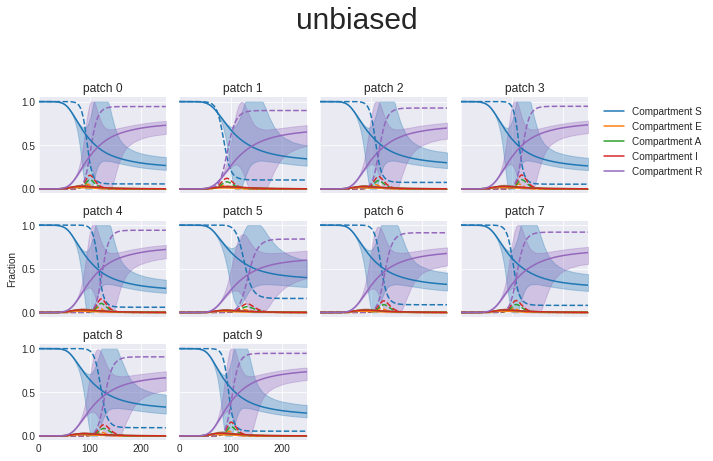

In [18]:
trajs = gen_samples(graph, timesteps =250, area = area, populations = population)
compare_to_ref(ref_traj, trajs, weights=None, method='unbiased', patch_names = patches,
               figsize=(10, 6), alpha=0.3, names=full_compartments)

Restraints are set in this time range: [50, 140]
108 0.12193877 0.11212121695257428
73 0.0036207337 0.0038797251678202842
94 0.10678939 0.0975767435195883
87 0.04323439 0.04401098610343091
59 0.00025152418 0.000262615577760034
129 0.91534317 0.9247260318306774
136 0.9323015 0.8844800862161573
94 0.16846609 0.1765778663938252
101 0.38889435 0.35987720729730543
87 0.054656204 0.05766202490664838
101 0.008898427 0.009280135439712367
136 0.09561337 0.10106859748241909
87 0.00077310385 0.0008297947320277079
80 0.00020885571 0.00021775872544651403
66 1.4287538e-05 1.3859873313300837e-05
80 0.0002363288 0.00022314286371231422
52 9.391268e-07 9.773736479515771e-07
108 0.03605605 0.03616228036515053
129 0.43952748 0.43546067309358144
73 6.142785e-05 5.894724157472124e-05
101 0.013229624 0.014386074464058159
66 1.4185339e-05 1.4401494873370354e-05
52 7.751748e-07 7.22970852288738e-07
136 0.06863286 0.06675074043577336
115 0.10382312 0.1062002880499519
80 0.00025487825 0.0002543202381060217
73 6.

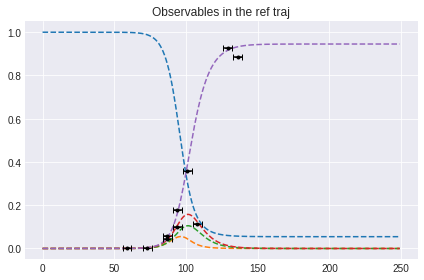

In [29]:
npoints = 5
number_of_restrained_patches = 5
restrained_compartments = [3,4] #(infected patch and recovered)
number_of_restrained_compartments = len(restrained_compartments) 
restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
restrained_compartments_names = " ".join(restrained_compartments_names)
restraints, plot_fxns_list, restrained_patches = gen_restraints(ref_traj, prior=False, start=50, end=140)

<AxesSubplot:ylabel='Count'>

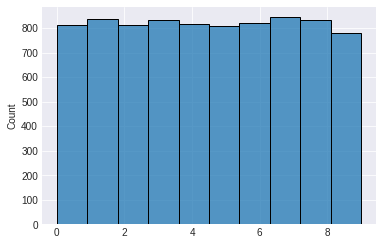

In [30]:
prior_exposed_patch = maxentep.exposed_finder(trajs)
sns.histplot(x=prior_exposed_patch, label='Prior',
            color='C0',bins=M)

In [31]:
def maxent_fit(trajs, restraints):
    me_model = maxentep.MaxentModel(restraints)
    from tensorflow import keras
    optimizer=keras.optimizers.Adam(lr=1e-2) 
    me_model.compile(optimizer=optimizer, loss='mean_squared_error')
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.9,
                              patience=10, min_lr=0)
    me_history = me_model.fit(trajs, batch_size=trajs.shape[0], epochs=200, callbacks=[reduce_lr])
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    ax[0].plot(me_history.history['loss'])
    ax[0].set_yscale('log')
    ax[0].set_title('loss')
#     ax[1].show()
    ax[1].plot(me_history.history['weight-entropy'])
    ax[1].set_title('weight-entropy')
    return me_model

Epoch 1/200
1/1 [==============================] - 0s 4ms/step - loss: 11.6491 - weight-entropy: 9.0109
Epoch 2/200
1/1 [==============================] - 0s 1ms/step - loss: 11.5439 - weight-entropy: 8.5684
Epoch 3/200
1/1 [==============================] - 0s 749us/step - loss: 12.4654 - weight-entropy: 8.4457
Epoch 4/200
1/1 [==============================] - 0s 817us/step - loss: 11.9907 - weight-entropy: 8.3934
Epoch 5/200
1/1 [==============================] - 0s 824us/step - loss: 10.9946 - weight-entropy: 8.3626
Epoch 6/200
1/1 [==============================] - 0s 801us/step - loss: 9.7774 - weight-entropy: 8.3364
Epoch 7/200
1/1 [==============================] - 0s 654us/step - loss: 8.4988 - weight-entropy: 8.3066
Epoch 8/200
1/1 [==============================] - 0s 803us/step - loss: 7.2625 - weight-entropy: 8.2692
Epoch 9/200
1/1 [==============================] - 0s 802us/step - loss: 6.1365 - weight-entropy: 8.2231
Epoch 10/200
1/1 [==============================] - 0s

Epoch 155/200
1/1 [==============================] - 0s 621us/step - loss: 0.2379 - weight-entropy: 6.3275
Epoch 156/200
1/1 [==============================] - 0s 845us/step - loss: 0.2370 - weight-entropy: 6.3236
Epoch 157/200
1/1 [==============================] - 0s 649us/step - loss: 0.2360 - weight-entropy: 6.3198
Epoch 158/200
1/1 [==============================] - 0s 832us/step - loss: 0.2351 - weight-entropy: 6.3160
Epoch 159/200
1/1 [==============================] - 0s 643us/step - loss: 0.2341 - weight-entropy: 6.3121
Epoch 160/200
1/1 [==============================] - 0s 795us/step - loss: 0.2332 - weight-entropy: 6.3083
Epoch 161/200
1/1 [==============================] - 0s 794us/step - loss: 0.2322 - weight-entropy: 6.3045
Epoch 162/200
1/1 [==============================] - 0s 814us/step - loss: 0.2313 - weight-entropy: 6.3007
Epoch 163/200
1/1 [==============================] - 0s 789us/step - loss: 0.2304 - weight-entropy: 6.2969
Epoch 164/200
1/1 [==================

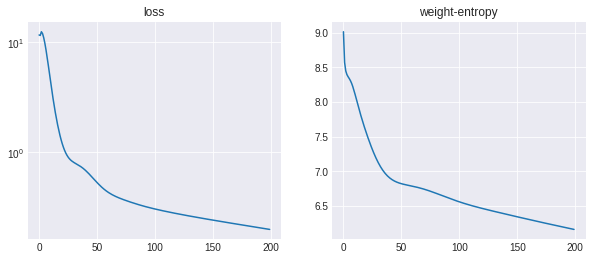

In [32]:
me_model = maxent_fit(trajs, restraints)

Plotting 10 patches in a 3 x 4 grid


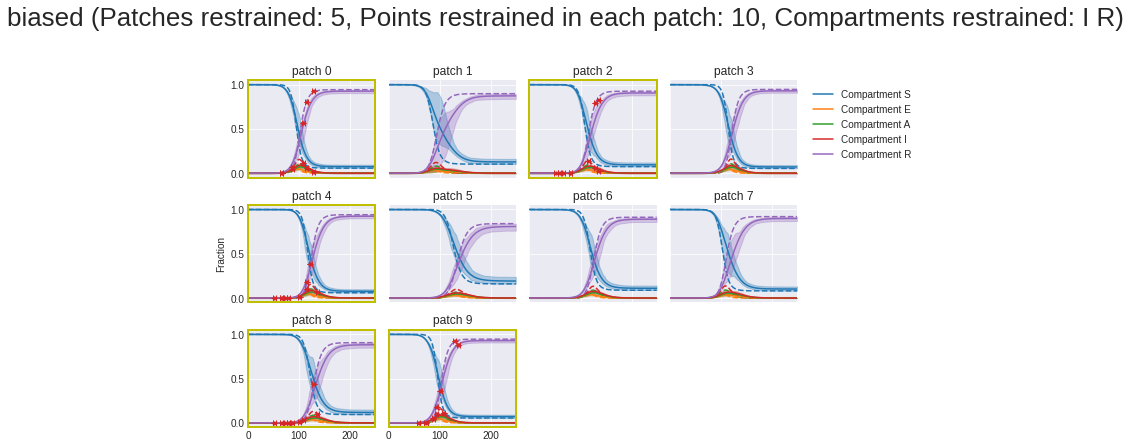

In [33]:
weights_dict = {'unbiased':None, 'biased':me_model.traj_weights}
compare_patches(ref_traj, trajs, weights_dict,'biased', restrained_patches, plot_fxns_list,
                patch_names = patches, figsize=(10, 6), alpha=0.3, names=full_compartments)

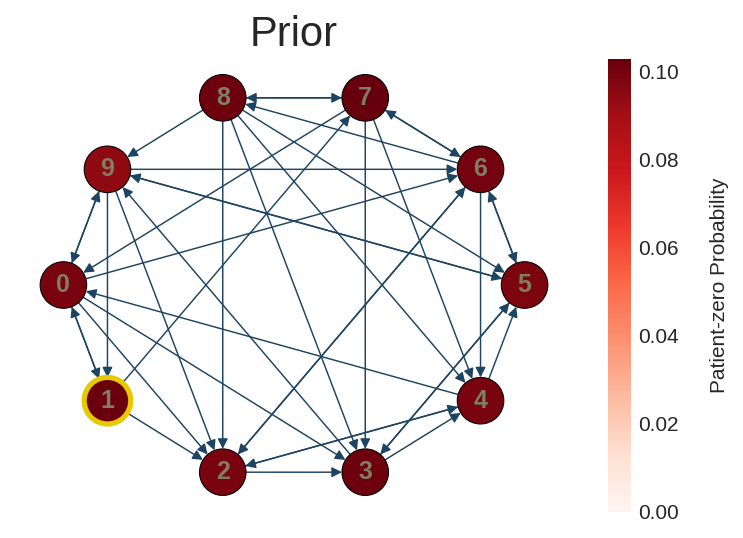

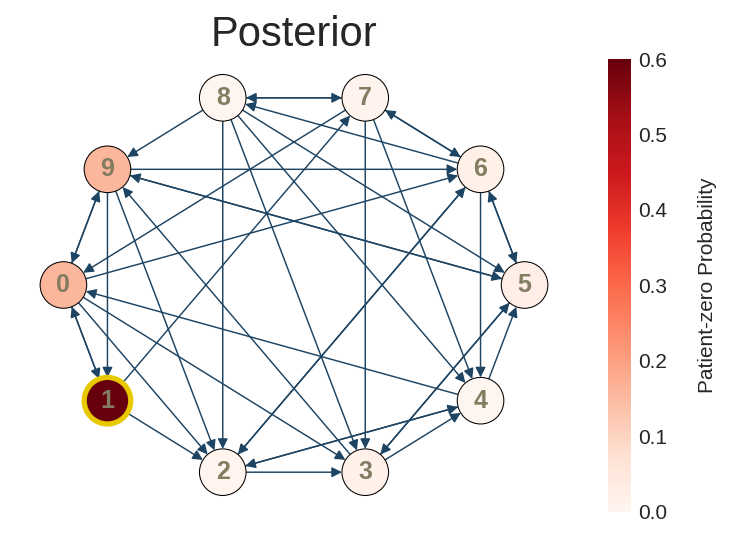

In [34]:
me_w = me_model.traj_weights
exposed_prob = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch, M)
weighted_exposed_prob = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch, M, weights=me_w)
maxentep.draw_graph(graph, weights=exposed_prob, title='Prior', heatmap=True, true_origin=true_node)
fig, ax = plt.subplots()
maxentep.draw_graph(graph, weights=weighted_exposed_prob, title='Posterior', heatmap=True, true_origin=true_node)

In [35]:
traj_loss = maxentep.traj_loss(ref_traj, trajs, me_w)
p0_loss = maxentep.p0_loss(trajs,me_w, true_node)
# posterior_exposed_prob = maxentep.weighted_exposed_prob_finder(prior_exposed_patch, M, weights = me_w)
print(f'P0 cross-entropy : {p0_loss:.3f}, Traj KL : {traj_loss:.3f}')
print('Top 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob, patches), reverse=True)[:5])

P0 cross-entropy : 0.509, Traj KL : 0.017
Top 5 posterior probabilities for P0: 
 [(0.6008076039520756, 'patch 1'), (0.1613976637628568, 'patch 9'), (0.16058091630206814, 'patch 0'), (0.025805887861626832, 'patch 5'), (0.018898941462862518, 'patch 6')]


In [7]:
n_samples = 1000
connecting_probability = np.linspace(0.25, 1, n_samples)
run_doe = False
dat=[]
if run_doe:
    for i,p in enumerate(connecting_probability):
        M=10
        true_node = np.random.randint(M)
        graph = maxentep.gen_random_graph(M,p)
        ref_traj = gen_ref_traj(graph, timesteps=250, population=population,
                                  area=area, true_node=true_node)
        trajs = gen_samples(graph, timesteps =250, area = area, populations = population)
        npoints = 5
        number_of_restrained_patches = 5
        restrained_compartments = [3,4] #(infected patch and recovered)
        number_of_restrained_compartments = len(restrained_compartments) 
        restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
        restrained_compartments_names = " ".join(restrained_compartments_names)
    #     plt.figure()
        restraints, plot_fxns_list, restrained_patches = gen_restraints(ref_traj, prior=True, start=50, end=140)
        prior_exposed_patch = maxentep.exposed_finder(trajs)
        me_model = maxent_fit(trajs, restraints)
        weights_dict = {'unbiased':None, 'biased':me_model.traj_weights}
        me_w = me_model.traj_weights
        exposed_prob = maxentep.weighted_exposed_prob_finder(
                                    prior_exposed_patch, M)
        weighted_exposed_prob = maxentep.weighted_exposed_prob_finder(
                                    prior_exposed_patch, M, weights=me_w)
        traj_loss = maxentep.traj_loss(ref_traj, trajs, me_w).numpy()
        p0_loss = maxentep.p0_loss(trajs,me_w, true_node)
        compare_patches(ref_traj, trajs, weights_dict,'biased', restrained_patches, plot_fxns_list,
                    patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)
        fig, ax = plt.subplots()
        maxentep.draw_graph(graph, weights=weighted_exposed_prob, title=f'Posterior - P = {p:.3f}', heatmap=True, true_origin=true_node)
        print(f'P0 cross-entropy : {p0_loss:.3f}, Traj KL : {traj_loss:.3f}')
        print(f'Iteration: {i}, p: {p}, True_node: {true_node}'
              '\nTop 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob, patches), reverse=True)[:5])
        p0_pred = sorted(zip(weighted_exposed_prob, patches), reverse=True)[:1][0]
        certainty = p0_pred[0]
        predcited_node = int(p0_pred[1].split()[1])
        if predcited_node == true_node:
            prediction = True
        else:
            prediction = False
        dat.append([traj_loss, p0_loss, certainty, prediction, true_node, predcited_node])
    with open('data.npz', 'wb') as f:
        np.save(f, dat)
else:
    results = np.load('data.npz')
    for f in results.files:
        dat.append(results[f].astype(float))
dat = np.array(dat)

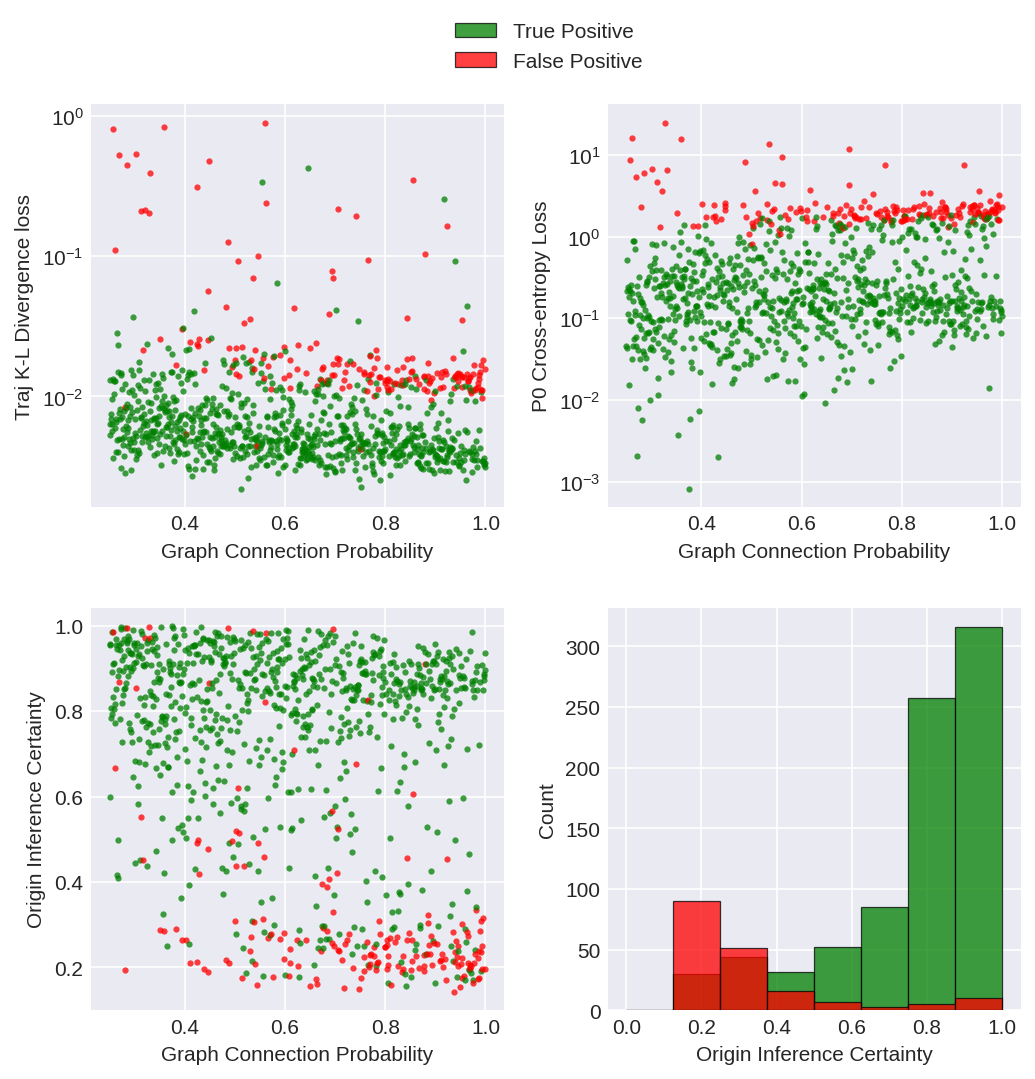

In [8]:
marker_colors = []
predictions = dat[:,3].astype(bool)
certainties = dat[:,2]
cross_entropy = dat[:,1]
K_L = dat[:,0]
true_nodes = dat[:,4]
predicted_nodes = dat[:,5]
alpha = 0.75
# K_L, cross_entropy, certainties, predictions, true_nodes, predicted_nodes = np.array(dat, dtype=object)
for i in range(len(connecting_probability)):
    if predictions[i]:
        marker_colors.append('g')
    else:
        marker_colors.append('r')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8), dpi=150)
ax[0,0].set_xlabel('Graph Connection Probability')
ax[0,0].set_ylabel('Traj K-L Divergence loss')
ax[0,0].set_yscale('log')
ax[0,1].set_xlabel('Graph Connection Probability')
ax[0,1].set_ylabel('P0 Cross-entropy Loss')
ax[0,1].set_yscale('log')
ax[1,0].set_xlabel('Graph Connection Probability')
ax[1,0].set_ylabel('Origin Inference Certainty')
fps = []
tps = []
for i, mc in enumerate(marker_colors):
    ax[0,0].plot(connecting_probability[i], K_L[i], marker='.', markerfacecolor=mc,
               markeredgecolor='None', label=f'{bool(predictions[i])} Positive', alpha=alpha)
    ax[0,1].plot(connecting_probability[i], cross_entropy[i], marker='.', markerfacecolor=mc,
               markeredgecolor='None', label=f'{bool(predictions[i])} Positive', alpha=alpha)
    ax[1,0].plot(connecting_probability[i], certainties[i], marker='.', markerfacecolor=mc,
               markeredgecolor='None', label=f'{bool(predictions[i])} Positive', alpha=alpha)
    if bool(predictions[i]):
        tps.append(certainties[i])
    else:
        fps.append(certainties[i])
bins = np.linspace(0, 1, 9)
counts_t, bins_t, bars_t = ax[1,1].hist(tps, bins, alpha=alpha, label='True Positive', color='g', rwidth=1, edgecolor='k', linewidth=0.6)
counts_f, bins_f, bars_f = ax[1,1].hist(fps, bins, alpha=alpha, label='False Positive', color='r', rwidth=1, edgecolor='k', linewidth=0.6)
ax[1,1].set_xlabel('Origin Inference Certainty')
ax[1,1].set_ylabel('Count')
fig.subplots_adjust(hspace=0.25, wspace=0.25)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[0,0].legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.38, 1.25))
bins_t = bins_t[1:]

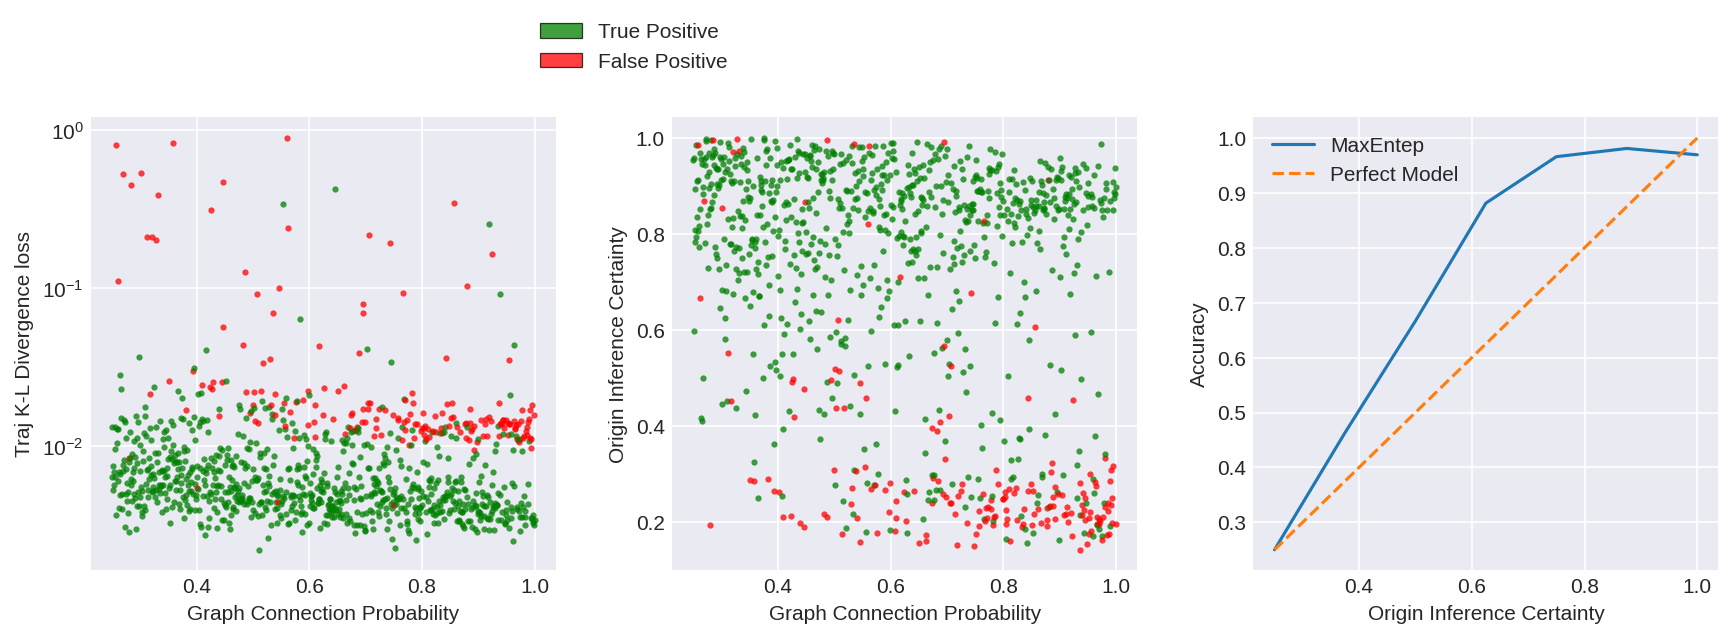

In [9]:
marker_colors = []
predictions = dat[:,3].astype(bool)
certainties = dat[:,2]
cross_entropy = dat[:,1]
K_L = dat[:,0]
true_nodes = dat[:,4]
predicted_nodes = dat[:,5]
alpha = 0.75
# K_L, cross_entropy, certainties, predictions, true_nodes, predicted_nodes = np.array(dat, dtype=object)
for i in range(len(connecting_probability)):
    if predictions[i]:
        marker_colors.append('g')
    else:
        marker_colors.append('r')
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14,4), dpi=150)
ax[0].set_xlabel('Graph Connection Probability')
ax[0].set_ylabel('Traj K-L Divergence loss')
ax[0].set_yscale('log')
ax[1].set_xlabel('Graph Connection Probability')
ax[1].set_ylabel('Origin Inference Certainty')
fps = []
tps = []
for i, mc in enumerate(marker_colors):
    ax[0].plot(connecting_probability[i], K_L[i], marker='.', markerfacecolor=mc,
               markeredgecolor='None', label=f'{bool(predictions[i])} Positive', alpha=alpha)
    ax[1].plot(connecting_probability[i], certainties[i], marker='.', markerfacecolor=mc,
               markeredgecolor='None', label=f'{bool(predictions[i])} Positive', alpha=alpha)
    if bool(predictions[i]):
        tps.append(certainties[i])
    else:
        fps.append(certainties[i])
bins = np.linspace(0, 1, 9)
counts_t, bins_t, bars_t = ax[2].hist(tps, bins, alpha=alpha, label='True Positive', color='g', rwidth=1, edgecolor='k', linewidth=0.6)
counts_f, bins_f, bars_f = ax[2].hist(fps, bins, alpha=alpha, label='False Positive', color='r', rwidth=1, edgecolor='k', linewidth=0.6)
fig.subplots_adjust(hspace=0.25, wspace=0.25)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[0].legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.41, 1.25))
bins_t = bins_t[1:]
accuracy = counts_t/(counts_f + counts_t)
# plt.figure(dpi=150)
ax[2].clear()
ax[2].plot(bins_t, accuracy, label='MaxEntep')
non_nan = np.min(np.where(np.isfinite(accuracy)))
ax[2].plot([bins_t[non_nan],1],[bins_t[non_nan],1], '--', label='Perfect Model')
ax[2].set_xlabel('Origin Inference Certainty')
ax[2].set_ylabel('Accuracy')
legend = plt.legend()

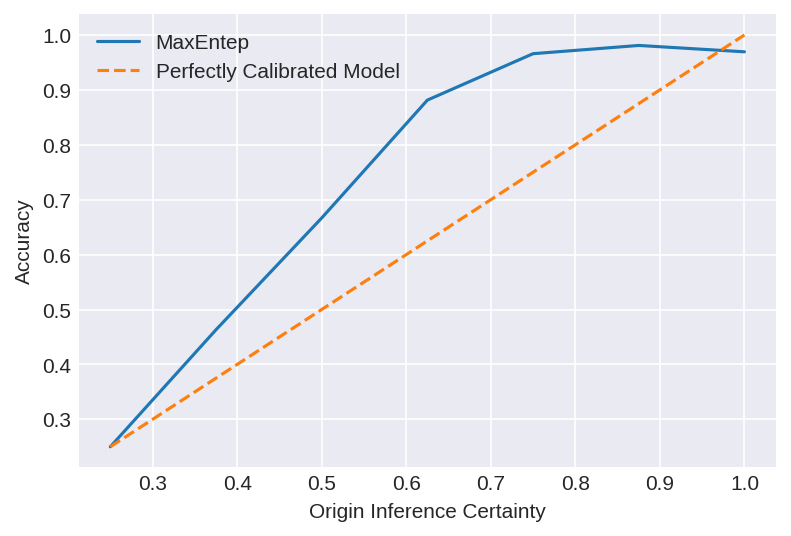

In [10]:
accuracy = counts_t/(counts_f + counts_t)
plt.figure(dpi=150)
plt.plot(bins_t, accuracy, label='MaxEntep')
non_nan = np.min(np.where(np.isfinite(accuracy)))
plt.plot([bins_t[non_nan],1],[bins_t[non_nan],1], '--', label='Perfectly Calibrated Model')
plt.xlabel('Origin Inference Certainty')
plt.ylabel('Accuracy')
legend = plt.legend()